In [38]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [39]:
batch_size = 16
epochs = 15
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2470, 0.2435, 0.2616])])
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified
Files already downloaded and verified


In [40]:

class network_g_19(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding = 1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding = 1)
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bn3(x)
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(x)
        x = self.bn4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = network_g_19()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.to(device)
criterion.to(device)
net

network_g_19(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [41]:
training_loss_history = []
testing_accuracy_history = []
testing_loss_history = []
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:# get mean loss every 2000 mini batches
            training_loss_history.append(running_loss / 2000)
            print(f"Training loss : {running_loss / 2000}")
            running_loss = 0.0
    correct = 0
    total = 0
    total_test_loss = 0.0
    with torch.no_grad():
        for i,  data in enumerate(testloader, 0):
            images, labels = data
            outputs = net(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.cuda().size(0)
            test_loss = criterion(outputs, labels.cuda())
            total_test_loss += test_loss.item()
            correct += (predicted == labels.cuda()).sum().item()
    testing_loss_history.append(total_test_loss / (len(test_data) / batch_size))
    print(f"Test loss : {total_test_loss / (len(test_data) / batch_size)}")
    total_test_loss = 0
    accuracy = 100 * correct / total
    testing_accuracy_history.append(accuracy)
    print(f"Test accuracy: {accuracy}")
print('Finished Training')

Epoch 0
Training loss : 1.5450557375848293
Test loss : 1.004070741701126
Test accuracy: 64.97
Epoch 1
Training loss : 0.8874699869006872
Test loss : 0.7835013254165649
Test accuracy: 73.67
Epoch 2
Training loss : 0.6629779868125916
Test loss : 0.6751829890012742
Test accuracy: 77.61
Epoch 3
Training loss : 0.5193276408519596
Test loss : 0.6321147286891937
Test accuracy: 79.34
Epoch 4
Training loss : 0.41750780437793583
Test loss : 0.605705209967494
Test accuracy: 80.91
Epoch 5
Training loss : 0.3283922395859845
Test loss : 0.6123945322155953
Test accuracy: 80.8
Epoch 6
Training loss : 0.26094657103245844
Test loss : 0.6291764681860804
Test accuracy: 81.76
Epoch 7
Training loss : 0.20948373675422044
Test loss : 0.6505448121607303
Test accuracy: 81.55
Epoch 8
Training loss : 0.1605514118160354
Test loss : 0.6590014979675413
Test accuracy: 82.3
Epoch 9
Training loss : 0.13676627235485647
Test loss : 0.6938493447974324
Test accuracy: 81.76
Epoch 10
Training loss : 0.104737769710453
Test lo

## Final run through the testing dataset to get the overall accuracy reading

In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.cuda().size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Test accuracy: {100 * correct / total} %')

Test accuracy: 83.59 %


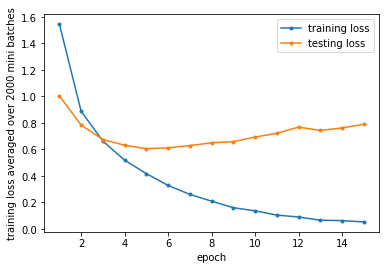

In [50]:
import seaborn as sns

plt.plot(range (1, epochs + 1), training_loss_history, marker = '.', label = "training loss")
plt.plot(range (1, epochs + 1), testing_loss_history, marker = '.', label = "testing loss")
plt.xlabel("epoch")
plt.ylabel("training loss averaged over 2000 mini batches")
plt.legend()
plt.savefig("training_loss.jpg")

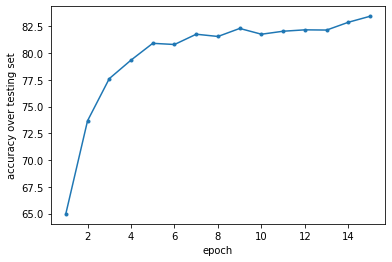

In [48]:
plt.plot(range(1, epochs + 1), testing_accuracy_history, marker = '.')
plt.xlabel("epoch")
plt.ylabel("accuracy over testing set")
plt.savefig("testing_accuracy.jpg")

In [52]:
correct_per_class = {classname: 0 for classname in classes}
total_per_class = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.cuda() == prediction:
                correct_per_class[classes[label.cuda()]] += 1
            total_per_class[classes[label.cuda()]] += 1


for classname, correct_count in correct_per_class.items():
    accuracy = 100 * float(correct_count) / total_per_class[classname]
    print(f'Accuracy for class: {classname} is {accuracy} %')

avg_acc = np.mean([correct_per_class[classname] / total_per_class[classname] for classname in classes])
print(avg_acc * 100)




Accuracy for class: plane is 86.1 %
Accuracy for class: car is 90.6 %
Accuracy for class: bird is 75.6 %
Accuracy for class: cat is 71.6 %
Accuracy for class: deer is 79.9 %
Accuracy for class: dog is 74.8 %
Accuracy for class: frog is 88.6 %
Accuracy for class: horse is 87.6 %
Accuracy for class: ship is 91.3 %
Accuracy for class: truck is 89.8 %
83.59


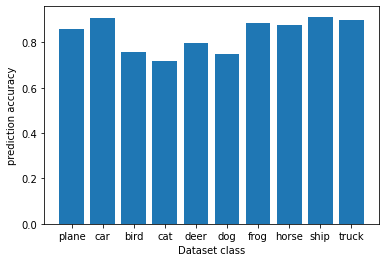

In [53]:
accuracy_by_class = {}
for classname in correct_per_class.keys():
    accuracy_by_class[classname] = correct_per_class[classname] / total_per_class[classname]
plt.bar(accuracy_by_class.keys(), accuracy_by_class.values())
plt.xlabel("Dataset class")
plt.ylabel("prediction accuracy")
plt.savefig("acc_by_class.jpg", transparent = False)